Database : https://www.kaggle.com/datasets/ricardofebra/vacuum-vibration-monitoring

In [16]:
# prompt: google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Model Performance (trained and tested on full dataset):
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1 Score : 1.0000

Classification Report:
                                            precision    recall  f1-score   support

                                   Unknown       1.00      1.00      1.00         1
   Low Speed, No Obstruction, Closed Cover       1.00      1.00      1.00         1
      Low Speed, Obstruction, Closed Cover       1.00      1.00      1.00         1
        Low Speed, Obstruction, Open Cover       1.00      1.00      1.00         1
     Low Speed, No Obstruction, Open Cover       1.00      1.00      1.00         1
Medium Speed, No Obstruction, Closed Cover       1.00      1.00      1.00         1
   Medium Speed, Obstruction, Closed Cover       1.00      1.00      1.00         1
     Medium Speed, Obstruction, Open Cover       1.00      1.00      1.00         1
  Medium Speed, No Obstruction, Open Cover       1.00      1.00      1.00         1
  High

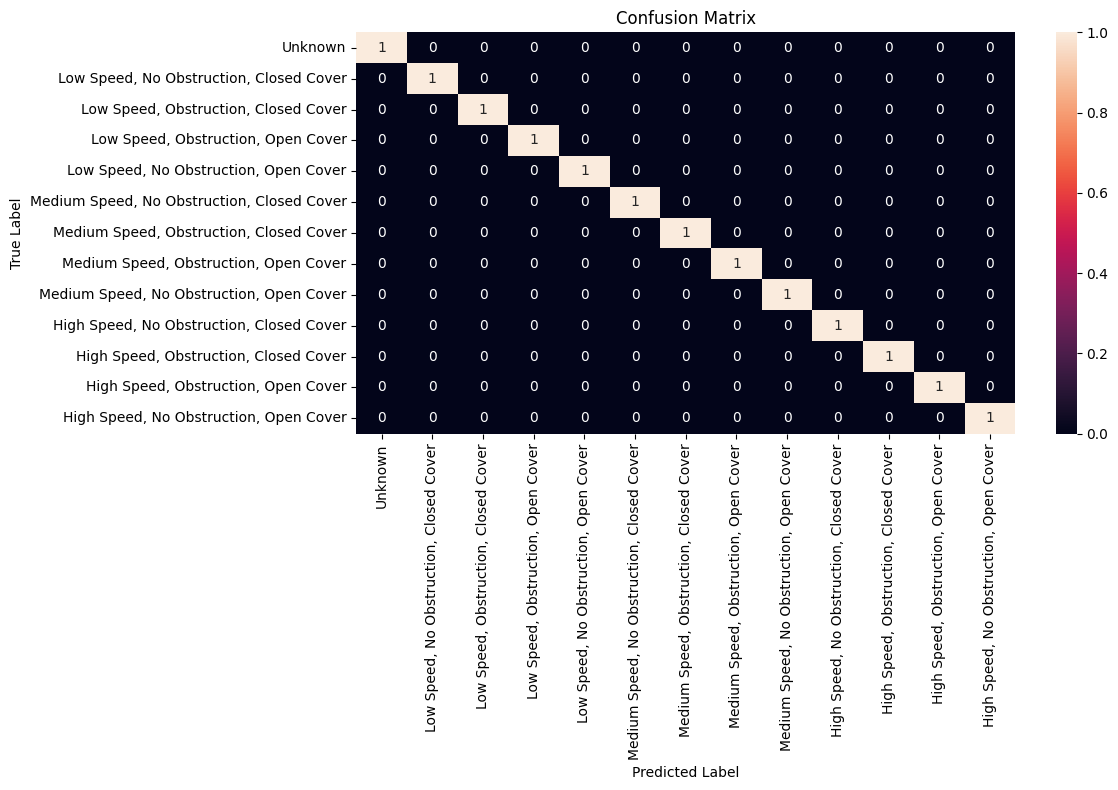

In [35]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)

# Label mapping
state_labels = {
    '00': 'Unknown',
    '01': 'Low Speed, No Obstruction, Closed Cover',
    '02': 'Low Speed, Obstruction, Closed Cover',
    '03': 'Low Speed, Obstruction, Open Cover',
    '04': 'Low Speed, No Obstruction, Open Cover',
    '05': 'Medium Speed, No Obstruction, Closed Cover',
    '06': 'Medium Speed, Obstruction, Closed Cover',
    '07': 'Medium Speed, Obstruction, Open Cover',
    '08': 'Medium Speed, No Obstruction, Open Cover',
    '09': 'High Speed, No Obstruction, Closed Cover',
    '10': 'High Speed, Obstruction, Closed Cover',
    '11': 'High Speed, Obstruction, Open Cover',
    '12': 'High Speed, No Obstruction, Open Cover'
}

# File paths
audio_files = sorted(glob.glob("/content/drive/MyDrive/vacum cleaner/Audio/*.csv"))
vibration_files = sorted(glob.glob("/content/drive/MyDrive/vacum cleaner/Vibration/*.csv"))

# Feature extraction function
def extract_features(signal):
    return [
        np.mean(signal),
        np.std(signal),
        np.min(signal),
        np.max(signal),
        np.median(signal),
        np.percentile(signal, 25),
        np.percentile(signal, 75),
        np.sum(np.square(signal)),
        np.count_nonzero(np.diff(np.sign(signal)))
    ]

# Prepare dataset
features, labels = [], []

for a_file, v_file in zip(audio_files, vibration_files):
    try:
        a_df = pd.read_csv(a_file)
        v_df = pd.read_csv(v_file)

        if 'mic' not in a_df.columns or not all(col in v_df.columns for col in ['acc_x', 'acc_y', 'acc_z']):
            continue

        state_code = os.path.basename(a_file).replace("label_", "").replace(".csv", "").zfill(2)

        a_signal = a_df['mic'].values.flatten()
        v_signal = v_df[['acc_x', 'acc_y', 'acc_z']].values.flatten()

        a_feat = extract_features(a_signal)
        v_feat = extract_features(v_signal)

        features.append(a_feat + v_feat)
        labels.append(state_code)
    except:
        continue

X = np.array(features)
y = np.array(labels)

if len(X) == 0:
    print("No valid data found.")
else:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    y_pred = clf.predict(X)

    print("\nModel Performance (trained and tested on full dataset):")
    print(f"Accuracy : {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred, average='weighted', zero_division=0):.4f}")
    print(f"Recall   : {recall_score(y, y_pred, average='weighted', zero_division=0):.4f}")
    print(f"F1 Score : {f1_score(y, y_pred, average='weighted', zero_division=0):.4f}")

    print("\nClassification Report:")
    print(classification_report(
        y, y_pred,
        target_names=[state_labels[l] for l in sorted(set(y))]
    ))

    plt.figure(figsize=(12, 8))
    cm = confusion_matrix(y, y_pred, labels=sorted(set(y)))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=[state_labels[l] for l in sorted(set(y))],
        yticklabels=[state_labels[l] for l in sorted(set(y))]
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
